# Libraries

In [1]:
import os
# Obtiene el nuevo directorio actual después del cambio
new_directory = '/Users/jyoung/Doctorado/embryo_classification/'
os.chdir(new_directory)
print("New actual directory:", new_directory)

# Elimino warnings molestas
import warnings
warnings.filterwarnings("ignore")

New actual directory: /Users/jyoung/Doctorado/embryo_classification/


In [17]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import cv2
import os
import torchvision.models as models
import torch.optim as optim
import tqdm
import torch.nn.functional as F  # Functions without parameters for neural network operations
from tqdm import tqdm

from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from torch.utils.data import Dataset, DataLoader, sampler
from sklearn.model_selection import KFold  # K-Folds cross-validator for model evaluation
from typing import Tuple, List, Union  # Typing for type hinting in function signatures
from torch.cuda.amp import autocast  # Automatic mixed precision training in PyTorch


# Functions

In [66]:
def train_one_epoch(model : torch.nn.Module,
                    optimizer : torch.optim.Optimizer,
                    data_loader : torch.utils.data.DataLoader,
                    device : str,
                    dtype : type = torch.float32,
                    scaler : torch.cuda.amp.GradScaler = None ) -> Tuple[float, float]:
    """
    Trains the model for one epoch using the provided data_loader.

    Args:
    - model: The neural network model to be trained.
    - optimizer: The optimizer used for training the model.
    - data_loader: The data loader providing training data.
    - device: The device on which the training will be performed (e.g., 'cpu' or 'cuda').
    - dtype (torch.dtype, optional): The data type used for the tensors (default: torch.float32).
    - scaler (torch.cuda.amp.GradScaler, optional): Gradient scaler for mixed precision training (default: None).

    Returns:
    - tuple: A tuple containing the average loss per sample and the accuracy for the epoch.
    """
    model.train()
    total_loss = 0.0
    correct = 0
    total_samples = 0

    for x, y in tqdm(data_loader):
        x, y = x.to(device=device, dtype=dtype), y.to(device=device, dtype=torch.long)
        optimizer.zero_grad()
        with autocast(enabled=(scaler is not None)):
            scores = model(x)
            loss = F.cross_entropy(scores, y)
        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * x.size(0)
        _, predicted = scores.max(1)
        correct += (predicted == y).sum().item()
        total_samples += x.size(0)

    return total_loss / total_samples, correct / total_samples


def accuracy(loader: torch.utils.data.DataLoader,
            model : torch.nn.Module,
            device : str,
            dtype : type = torch.float32) -> float:
    """
    Calculates accuracy on a given data loader using the provided model.

    Args:
    - loader: The data loader to calculate accuracy on.
    - model: The neural network model to evaluate.
    - device: The device on which the evaluation will be performed (e.g., 'cpu' or 'cuda').
    - dtype (torch.dtype, optional): The data type used for the tensors (default: torch.float32).

    Returns:
    - float: The accuracy of the model on the given data loader.
    """
    print(f'Checking accuracy')

    model.eval()
    num_correct = 0
    num_samples = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device=device, dtype=dtype), y.to(device=device, dtype=torch.long)

            scores = model(x)
            _, preds = scores.max(1)
            
            num_correct += (preds == y).sum().item()
            num_samples += preds.size(0)
        
        accuracy = num_correct / num_samples if num_samples > 0 else 0
        print(f'Got {num_correct} / {num_samples} correct ({100 * accuracy:.2f}%)')
    
    return accuracy


def get_pretrained_model(model_name: str) -> torch.nn.Module:
    """
    Loads a pre-trained model based on the specified model name.

    Args:
    - model_name (str): The name of the pre-trained model ('vgg16', 'resnet50', 'inceptionv3', or 'mobilenetv2').

    Returns:
    - torch.nn.Module: The pre-trained model specified by the model_name.
    """
    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
    elif model_name == 'inceptionv3':
        model = models.inception_v3(pretrained=True)
    else:
        raise ValueError('Model not recognized. Choose from vgg16, resnet50, inceptionv3, or mobilenetv2')
    
    return model

def convert(x):
    if x=='A':
        return 0
    if x=='B':
        return 1
    if x=='C':
        return 2

# Load data

## Load labels

In [4]:
directory = 'data/CEM_database/'

with open(directory + 'blasts.pkl', 'rb') as f:
    blast_information = pickle.load(f)

n_data = len(blast_information)

y_ICM = np.zeros(n_data, dtype=int)
y_TE = np.zeros(n_data, dtype=int)
y_Exp = np.zeros(n_data, dtype=int)

y_ICM_letras = []
y_TE_letras = []
y_Exp_letras = []

for i in np.arange(1,n_data-1):
  label_ICM = convert(blast_information[str(i)][0][2][0])
  label_TE = convert(blast_information[str(i)][0][2][1])
  label_Exp = int(blast_information[str(i)][0][3])
  label_Exp = label_Exp - 1

  y_ICM[i] = label_ICM
  y_TE[i] = label_TE
  y_Exp[i] = label_Exp



## Check class balance

(array([ 475., 1362., 1594., 1675.,  399.,   18.]),
 array([0., 1., 2., 3., 4., 5., 6.]),
 <BarContainer object of 6 artists>)

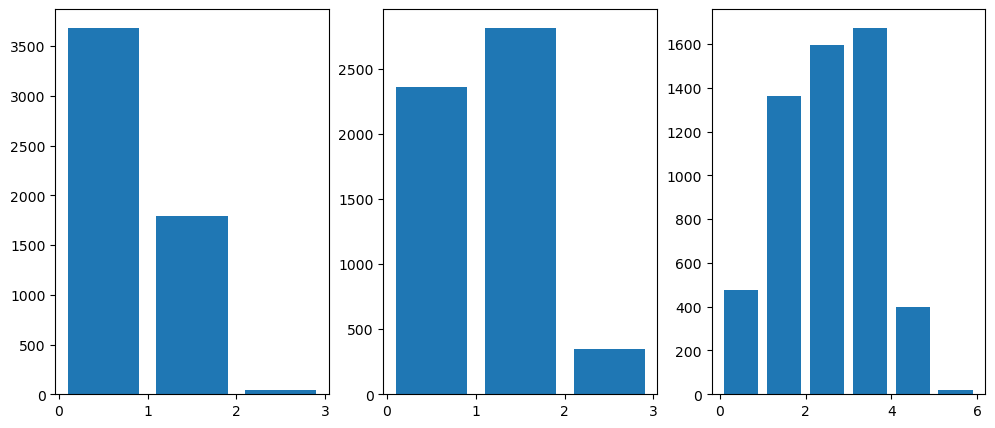

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,5))
ax1.hist(y_ICM,[0,1,2,3], rwidth=0.8)
ax2.hist(y_TE,[0,1,2,3], rwidth=0.8)
ax3.hist(y_Exp,[0,1,2,3,4,5,6], rwidth=0.8)

# Creo el dataset

In [53]:
class EmbryoDataset():
    def __init__(self, img_dir, labels, selected_images, images_labels):
        self.img_labels = labels[images_labels]  # Store the image labels
        self.img_dir = img_dir  # Store the directory containing the images
        self.selected_images = selected_images

        # Define a series of image transformations using torchvision's Compose
        self.transforms = T.Compose([T.ToPILImage(), 
                                T.Pad(100,padding_mode='reflect'), 
                                T.RandomHorizontalFlip(p=0.5), 
                                T.RandomRotation([0, 350], fill=100), 
                                T.CenterCrop(300), 
                                T.ToTensor()])
    def __len__(self):
        return len(self.img_labels)  # Return the total number of images in the dataset

    def __getitem__(self, idx):
        i = self.selected_images[idx]
        img_path = os.path.join(self.img_dir, str(i)+'.jpg')
        image = img_to_array(load_img(img_path))

        image = np.uint8(image.squeeze())
        image = cv2.resize(image, (300,300), interpolation = cv2.INTER_AREA)
        label = self.img_labels[idx]
        image = self.transforms(image)
        
        return image, label


## Load high quality images

In [45]:
selected_size = 1447200
selected_index = []
selected_label_index = []

for i in np.arange(1,n_data+1):

    img_path = os.path.join(directory, str(i)+'.jpg')
    image = img_to_array(load_img(img_path))

    if image.size == selected_size:
        selected_index.append(i)
        selected_label_index.append(i-1)

## Sample image

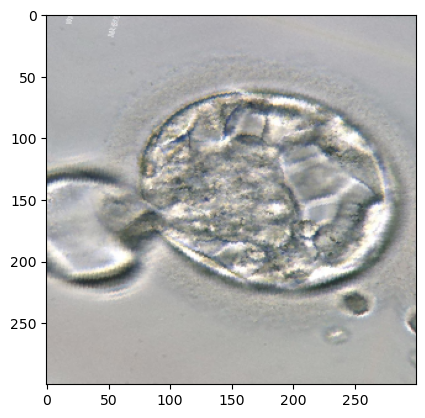

In [63]:
img_dir = 'data/CEM_database/'
labels = y_ICM
selected_images = selected_index
images_labels = selected_label_index

instanced_example = EmbryoDataset(img_dir, labels, selected_images, images_labels)

plt.imshow(np.swapaxes(instanced_example.__getitem__(0)[0],0,2))

## Create test y training datasets

In [50]:
def create_dataloaders(dataset, train_index, val_index, batch_size=32):

    # Divide los datos en conjunto de entrenamiento y validación para este pliegue
    train_dataset = torch.utils.data.Subset(dataset, train_index)
    valid_dataset = torch.utils.data.Subset(dataset, val_index)

    y_train_indices = train_dataset.indices
    y_train = [dataset.img_labels[i] for i in y_train_indices]
    class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])

    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in y_train])
    samples_weight = torch.from_numpy(samples_weight)

    weighted_sampler = torch.utils.data.WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

    loader_train = DataLoader(train_dataset, batch_size=batch_size, sampler=weighted_sampler)
    loader_val = DataLoader(valid_dataset, batch_size=batch_size, sampler=sampler.SequentialSampler(valid_dataset))

    return loader_train, loader_val


# Training

In [62]:
directory = 'data/CEM_database/'

model_name = 'vgg16'  # Aquí elige el modelo que quieras utilizar

# Definición de otros hiperparámetros
learning_rate = 0.001
batch_size = 64
num_epochs = 2

size2 = 1447200
train_proportion = 0.8
valid_proportion = 0.2

labels = y_ICM

In [70]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have defined your EmbryoDataset, model, and other necessary components

# Hyperparameters
num_epochs = 5
learning_rate = 0.001
batch_size = 32

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create DataLoader for training and validation
instanced_dataset = EmbryoDataset(img_dir, labels, selected_images, images_labels)
train_loader = DataLoader(instanced_dataset, batch_size=batch_size, shuffle=True)

# Split the dataset into training and validation sets (e.g., 80% training, 20% validation)
train_size = int(train_proportion * len(instanced_dataset))
val_size = len(instanced_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(instanced_dataset, [train_size, val_size])

# Calculate class weights for balancing
y_train_indices = train_dataset.indices
y_train = [instanced_dataset.img_labels[i] for i in y_train_indices]
class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
weight = 1.0 / class_sample_count
samples_weight = np.array([weight[t] for t in y_train])
samples_weight = torch.from_numpy(samples_weight)

# Create WeightedRandomSampler for training
weighted_sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

# Create DataLoaders with WeightedRandomSampler
loader_train = DataLoader(train_dataset, batch_size=batch_size, sampler=weighted_sampler)
loader_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Create model and optimizer
model = get_pretrained_model(model_name)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create a learning rate scheduler
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Lists to store training and validation losses
train_losses = []
val_losses = []

# Training loop with validation, class balancing, and learning rate scheduler
for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_loss = 0.0
    correct = 0
    total_samples = 0

    for x, y in tqdm(loader_train, desc=f'Training Epoch {epoch + 1}/{num_epochs}'):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        scores = model(x)
        loss = F.cross_entropy(scores, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        _, predicted = scores.max(1)
        correct += (predicted == y).sum().item()
        total_samples += x.size(0)

    average_loss = total_loss / total_samples
    accuracy = correct / total_samples
    print(f"Training Epoch {epoch + 1}/{num_epochs}, Average Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}")

    # Validation phase
    model.eval()
    val_correct = 0
    val_total_samples = 0
    val_total_loss = 0.0

    with torch.no_grad():
        for val_x, val_y in tqdm(loader_val, desc=f'Validation Epoch {epoch + 1}/{num_epochs}'):
            val_x, val_y = val_x.to(device), val_y.to(device)

            val_scores = model(val_x)
            _, val_predicted = val_scores.max(1)
            val_correct += (val_predicted == val_y).sum().item()
            val_total_samples += val_x.size(0)

            val_loss = F.cross_entropy(val_scores, val_y)
            val_total_loss += val_loss.item() * val_x.size(0)

    val_accuracy = val_correct / val_total_samples
    val_loss = val_total_loss / val_total_samples
    print(f"Validation Epoch {epoch + 1}/{num_epochs}, Validation Accuracy: {val_accuracy:.4f}, Validation Loss: {val_loss:.4f}")

    # Store losses for plotting
    train_losses.append(average_loss)
    val_losses.append(val_loss)

    # Adjust learning rate based on validation loss
    lr_scheduler.step(val_loss)

# Optionally, you can perform additional evaluation on the test set after training
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# test_accuracy = evaluate_model(model, test_loader, device)
# print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Training Epoch 1/5:   1%|          | 1/81 [00:41<54:49, 41.12s/it]

In [ ]:
# Crea un objeto KFold para dividir tus datos
kf = KFold(n_splits=num_folds, shuffle=True)

# Creación del modelo elegido
model = get_pretrained_model(model_name)

# Resto del código para el entrenamiento
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Seleccionar el optimizador
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Instancio el dataset
region_specific=False #Activates or deactivates choosing only the features of a single region (or all)
region=None           #Chooses region (only if region_specific=True)
InstancedEmbryoDataset = EmbryoDataset(img_dir, labels, selected_images)

# Loop sobre los pliegues (folds)
for fold, (train_index, val_index) in enumerate(kf.split(InstancedEmbryoDataset)):
    print(f"Fold {fold + 1}/{num_folds}")

    loader_train, loader_val = create_dataloaders(labels, selected_index, train_index, val_index)


    train_loss, train_acc = train_one_epoch(model, optimizer, loader_train, device)
    print(f"Epoch [{fold + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

    val_acc = accuracy(loader_val, model, device)
    print(f"Epoch [{fold + 1}/{num_epochs}], Validation Acc: {val_acc:.4f}")


In [ ]:
class EmbryoDataset(Dataset):
    def __init__(self, img_dir, labels, selected_index, region_specific=False, region=None):

        self.img_labels = labels[selected_index]  # Store the image labels
        self.img_dir = img_dir  # Store the directory containing the images
        self.region_specific = region_specific
        self.selected_index = selected_index
        
        if region_specific:
            self.region = region
            self.mask_dir = 'data/segmented_CEM_database/GT_' + region

        # Define a series of image transformations using torchvision's Compose
        self.transform = T.Compose([
            T.Pad(100, padding_mode='reflect'),  # Padding the images
            T.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally with a 50% probability
            T.RandomRotation(degrees=(0, 350), fill=100),  # Randomly rotate the image between -10 and 10 degrees
            T.Resize((400, 400)),  # Resize the image to (400, 400)
            T.CenterCrop(300),  # Center crop the resized image to a final size of (300, 300)
            T.ToTensor()  # Convert the image to a PyTorch tensor
        ])

    def __len__(self):
        return len(self.img_labels)  # Return the total number of images in the dataset

    def __getitem__(self, idx):
        i = self.selected_index[idx]
        img_path = os.path.join(self.img_dir, str(i)+'.jpg')
        image = img_to_array(load_img(img_path))

        image = np.uint8(image.squeeze())
        label = self.img_labels[idx]
        image = Image.fromarray(image)  # Convert the image to a PIL Image
        image = self.transform(image)

        if self.region_specific:
            mask_path = os.path.join(self.mask_dir, str(idx + 1) + '.bmp')
            mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)  # Read the image using OpenCV
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)  # Convert the image from BGR to RGB format
            mask = Image.fromarray(mask)  # Convert the image to a PIL Image
            mask = self.transform(mask)  # Apply the defined transformations to the image
            image = image * mask

        return image, label  # Return the transformed image and its label
